In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import numpy as np

In [2]:
ensgid = pd.read_csv('/home/jiageng/Documents/fhr/annotations/ensgid-autosomal-proteincoding.txt', sep='\t', skiprows=1, names=['gid','gname','Chromosome','Start','End'])

In [3]:
ensgid_index = ensgid.set_index(['gid','gname']).index

In [4]:
mutfile = '/home/jiageng/Documents/fhr/data/IGV Downloads_MMRF_CoMMpass_IA22_exome_vcfmerger2_IGV_All_Canonical_NS_Variants.mut'
df = pd.read_csv(mutfile, sep='\t', header=0).assign(PUBLIC_ID=lambda x: x['sample'].str.extract(r'(MMRF_\d{4})'))

first_samples = df.sort_values('sample').groupby('PUBLIC_ID').head(1)['sample'].unique()
df1 = df[df['sample'].isin(first_samples)]

In [5]:
ensgid

,gid,gname,Chromosome,Start,End
0,ENSG00000142611,PRDM16,1,3069168,3438621
1,ENSG00000157911,PEX10,1,2403964,2413797
2,ENSG00000142655,PEX14,1,10472288,10630758
3,ENSG00000149527,PLCH2,1,2425980,2505532
4,ENSG00000171621,SPSB1,1,9292894,9369532
...,...,...,...,...,...
18805,ENSG00000170777,TPD52L3,9,6328375,6331891
18806,ENSG00000147854,UHRF2,9,6413151,6507056
18807,ENSG00000136877,FPGS,9,127794597,127814494
18808,ENSG00000165025,SYK,9,90801787,90898549


In [6]:
counts_per_gene = df1.groupby(['GENEID','GENE','sample']).size().reset_index(name='counts')

In [7]:
counts_per_gene.dtypes

GENEID    object
GENE      object
sample    object
counts     int64
dtype: object

In [8]:
counts_mat = counts_per_gene.pivot(index=['GENEID','GENE'],columns='sample',values='counts').convert_dtypes(convert_integer=True).fillna(0)

In [9]:
counts_mat.shape

(15787, 974)

In [10]:
counts_mat.index

MultiIndex([('ENSG00000000005',       'TNMD'),
            ('ENSG00000000419',       'DPM1'),
            ('ENSG00000000457',      'SCYL3'),
            ('ENSG00000000460',   'C1orf112'),
            ('ENSG00000000971',        'CFH'),
            ('ENSG00000001036',      'FUCA2'),
            ('ENSG00000001084',       'GCLC'),
            ('ENSG00000001167',       'NFYA'),
            ('ENSG00000001461',     'NIPAL3'),
            ('ENSG00000001497',      'LAS1L'),
            ...
            ('ENSG00000287694', 'AC106741.1'),
            ('ENSG00000287725', 'AP003071.5'),
            ('ENSG00000287856', 'AL445524.2'),
            ('ENSG00000288000', 'AL031681.2'),
            ('ENSG00000288053', 'AC231657.3'),
            ('ENSG00000288064', 'AC067945.4'),
            ('ENSG00000288208', 'AL451136.1'),
            ('ENSG00000288380',     'CRIPAK'),
            ('ENSG00000288436', 'AC024558.2'),
            ('ENSG00000288520', 'AL357075.5')],
           names=['GENEID', 'GENE'], length

In [11]:
counts_mat_proteincoding = counts_mat.loc[ pd.Index(set(counts_mat.index).intersection(set(ensgid_index))) ]
counts_mat_proteincoding.shape

(14301, 974)

In [12]:
counts_mat_full = counts_mat_proteincoding.reindex(ensgid_index, fill_value=0).loc[ensgid_index]
counts_mat_full.shape

(18810, 974)

In [25]:
counts_mat_full.dtypes

sample
MMRF_1016_1_BM_CD138pos    Int64
MMRF_1020_3_BM_CD138pos    Int64
MMRF_1021_1_BM_CD138pos    Int64
MMRF_1024_2_BM_CD138pos    Int64
MMRF_1029_1_BM_CD138pos    Int64
                           ...  
MMRF_2918_1_BM_CD138pos    Int64
MMRF_2921_1_BM_CD138pos    Int64
MMRF_2923_1_BM_CD138pos    Int64
MMRF_2924_1_BM_CD138pos    Int64
MMRF_2926_1_BM_CD138pos    Int64
Length: 974, dtype: object

In [54]:
# sample as rows, gene as columns
counts_mat_t = counts_mat_proteincoding.reset_index().drop(columns='GENE').set_index('GENEID').T.reset_index().assign(PUBLIC_ID=lambda x: x['sample'].str.extract(r'(MMRF_\d{4})')).rename(columns={'sample':'SAMPLE'}).set_index(['PUBLIC_ID','SAMPLE'])

In [57]:
counts_mat_t.to_csv('../matrices/gene_mut_matrix.tsv.gz',sep='\t')

In [56]:
counts_mat_t.loc[:,counts_mat_t.sum(axis=0) >= 2].to_csv('../matrices/gene_mut_matrix_gt1.tsv.gz',sep='\t')

Plot top mutated genes

In [106]:
mutations_per_gene = counts_mat_full.sum(axis=1).sort_values(ascending=False)
mutations_per_gene.head()

gid              gname 
ENSG00000133703  KRAS      283
ENSG00000213281  NRAS      222
ENSG00000254709  IGLL5     184
ENSG00000155657  TTN       167
ENSG00000183508  TENT5C    149
dtype: Int64

In [133]:
np.mean(mutations_per_gene == 0)

np.float64(0.23971291866028707)

In [134]:
np.mean(mutations_per_gene >= 5)

np.float64(0.1988835725677831)

In [138]:
mutations_per_gene[mutations_per_gene >= 10]

gid              gname   
ENSG00000133703  KRAS        283
ENSG00000213281  NRAS        222
ENSG00000254709  IGLL5       184
ENSG00000155657  TTN         167
ENSG00000183508  TENT5C      149
                            ... 
ENSG00000077782  FGFR1        10
ENSG00000156931  VPS8         10
ENSG00000178772  CPN2         10
ENSG00000153404  PLEKHG4B     10
ENSG00000069020  MAST4        10
Length: 993, dtype: Int64

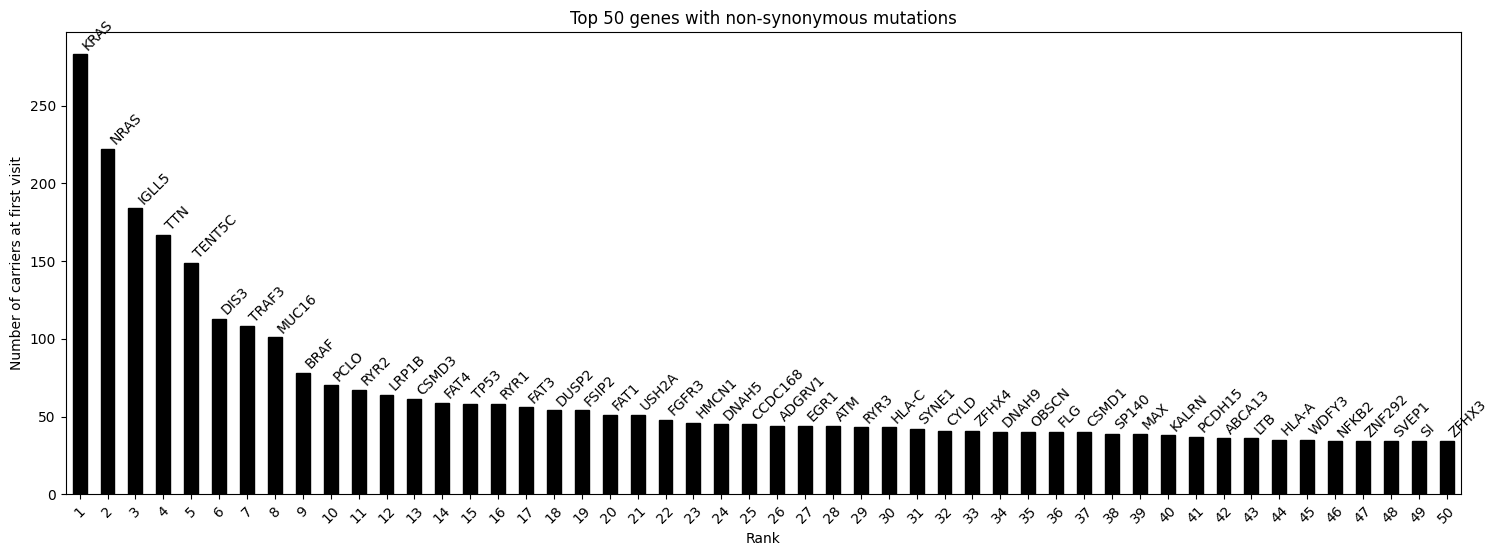

<Figure size 640x480 with 0 Axes>

In [128]:
import matplotlib.pyplot as plt

# Select the top 50 genes with the highest mutations
top_50_genes = mutations_per_gene.head(50)

# Plot the barplot
plt.figure(figsize=(18, 6))
ax = top_50_genes.plot(kind='bar', color='black', edgecolor='black')

# Annotate the gene names at the y location of the bars
for i, (gene, count) in enumerate(top_50_genes.items()):
    ax.text(i, count + 1, gene[1], ha='left', va='bottom', rotation=45)

# Set labels and title
ax.set_xlabel('Rank')
ax.set_ylabel('Number of carriers at first visit')
ax.set_title('Top 50 genes with non-synonymous mutations')
ax.set_xticklabels(range(1, 51), rotation=45, ha='center')
# ax.set_xticklabels([gene[1] for gene in top_50_genes.index], rotation=45, ha='right')

plt.show()
plt.savefig('../assets/ns-mutations-histogram.svg')